In [1]:
using Gen
using PyPlot
using PyCall

In [2]:
py"""
environment.close()

from IPython.display import HTML
import yaml
from animalai.envs.arena_config import ArenaConfig
from animalai.envs.environment import AnimalAIEnvironment
from mlagents_envs.exception import UnityCommunicationException
import random
import copy
import numpy as np
import math
from collections import defaultdict

conf_file = '/Users/aidancurtis/AnimalAI-Olympics/examples/configurations/curriculum/0.yml'
yaml_data = yaml.load(open(conf_file, "r"), Loader=yaml.Loader)

# random position
yaml_data.arenas[-1].items[0].positions[0].z = 10
# print(yaml_data.arenas[-1].items[0].positions[0].y)
# print(yaml_data.arenas[-1].items[0].positions[0].z)
goal_pose = (random.uniform(0, 40), 0, random.uniform(0, 40), 0)

yaml_data.arenas[-1].items[1].positions[0].x = goal_pose[0]
yaml_data.arenas[-1].items[1].positions[0].y = goal_pose[1]
yaml_data.arenas[-1].items[1].positions[0].z = goal_pose[2]


x=yaml_data.arenas[-1].items[0].positions[0].x
y=yaml_data.arenas[-1].items[0].positions[0].y
z=yaml_data.arenas[-1].items[0].positions[0].z
r = yaml_data.arenas[-1].items[0].rotations[0]

ACTIONS = [[1, 0],
          [1, 1], 
          [1, 2]]

framerate = 60
 
agent_start_pose = (x, y, z, r)
print(goal_pose)


def new_pose(start_pose, vel):
    return list((start_pose[i]+vel[i] for i in range(4)))

def set_pose(data, pose):
    cp_yaml_data = copy.deepcopy(data)
    cp_yaml_data.arenas[-1].items[0].positions[0].x = pose[0]
    cp_yaml_data.arenas[-1].items[0].positions[0].y = pose[1]
    cp_yaml_data.arenas[-1].items[0].positions[0].z = pose[2]
    cp_yaml_data.arenas[-1].items[0].rotations[0] = pose[3]
    return cp_yaml_data
resolution=64
try:
    environment = AnimalAIEnvironment(
            file_name='/Users/aidancurtis/aaio_mac',
            base_port=5024,
            resolution=resolution,
#             play=True,
            arenas_configurations=yaml_data,

        )
except UnityCommunicationException:
    # you'll end up here if you close the environment window directly
    # always try to close it from script
    environment.close()

agent_groups = environment.get_agent_groups()
agent_group_spec = environment.get_agent_group_spec(agent_groups[0])
agent_group = agent_groups[0] 

"""



LoadError: PyError ($(Expr(:escape, :(ccall(#= /Users/aidancurtis/.julia/packages/PyCall/BD546/src/pyeval.jl:38 =# @pysym(:PyEval_EvalCode), PyPtr, (PyPtr, PyPtr, PyPtr), o, globals, locals))))) <class 'NameError'>
NameError("name 'environment' is not defined")
  File "/Users/aidancurtis/.julia/packages/PyCall/BD546/src/pyeval.jl", line 1, in <module>
    const Py_single_input = 256  # from Python.h


In [3]:
struct ArrayNoiseModel <: Gen.Distribution{Array{Float64, 3}} end
const array_noise_model = ArrayNoiseModel()

function Gen.logpdf(::ArrayNoiseModel,
        x::Array{Float64, 3},
        mu::Array{Float64, 3})
    diffs = (x .- mu)
    return -sum(diffs .^ 2)
end

Gen.has_argument_grads(::ArrayNoiseModel) = (true,)
Gen.has_output_grad(::ArrayNoiseModel) = false

function Gen.logpdf_grad(::ArrayNoiseModel,
        x::Array{Float64, 3},
        mu::Array{Float64, 3})
    diffs = x .- mu
    mu_grad = 2 * diffs
    return (nothing, mu_grad)
end


function Gen.random(::ArrayNoiseModel,
        x::Array{Float64, 3})
    diffs = x
    return diffs
end


struct NoiseModel <: Gen.Distribution{Matrix{Float64}} end
const noise_model = NoiseModel()

function Gen.logpdf(::NoiseModel,
        x::Matrix{Float64},
        mu::Matrix{Float64})
    diffs = (x .- mu)
    return -sum(diffs .^ 2)
end

Gen.has_argument_grads(::NoiseModel) = (true,)
Gen.has_output_grad(::NoiseModel) = false

function Gen.logpdf_grad(::NoiseModel,
        x::Matrix{Float64},
        mu::Matrix{Float64})
    diffs = x .- mu
    mu_grad = 2 * diffs
    return (nothing, mu_grad)
end


In [4]:

@gen function model(T::Int)
    

    xs = Vector{Float64}(undef, T+1)
    zs = Vector{Float64}(undef, T+1)
    rs = Vector{Float64}(undef, T+1)

    # prior on initial x-coordinate
    x = @trace(uniform(0, 40), :x0)
       
    # prior on initial y-coordinate
    z = @trace(uniform(0, 40), :y0)
    
    # prior on initial rotation
    r = @trace(uniform(0, 360), :r0)

    # record position
    xs[1] = x
    zs[1] = z
    rs[1] = r
    
    # generate successive states and measurements
    for t=1:T
        # capture observation
        py"""
        def gen_obs(cur_node, yaml_data):
            new_yaml_data = set_pose(yaml_data, cur_node)
            environment.reset(arenas_configurations=new_yaml_data)
            environment.step()
            step_result = environment.get_step_result(agent_group)
            visual_observation = step_result.obs[0]
            return visual_observation
        """
        
        vis = py"gen_obs"([x, 0, z, rs[t]], py"yaml_data")
        sq_vis = reshape(vis, (size(vis, 2), size(vis, 3), size(vis, 4)) )
        sq_vis_f64 = convert(Array{Float64, 3}, sq_vis)
        @trace(array_noise_model(sq_vis_f64), (:obs, t))
        
        

        # record position
        xs[t+1] = @trace(normal(x, 0.01), (:vx, t))  
        zs[t+1] = @trace(normal(z, 0.01), (:vz, t))  
        rs[t+1] = @trace(normal(( rs[t]+6)%360, 0.01), (:vr, t)) 
    end
    
    # return the sequence of positions
    return (xs, zs)
end;

Array{Float64, 3}
Array{Float64, 3}
Array{Float64, 3}
Array{Float64, 3}
Array{Float64, 3}
Array{Float64, 3}
Array{Float64, 3}
Array

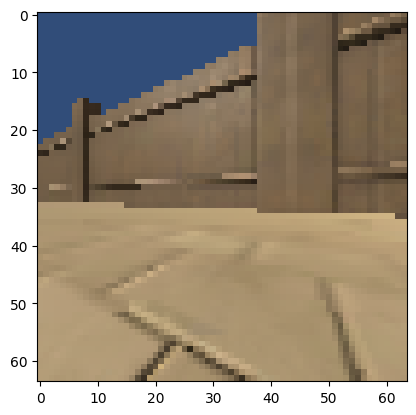

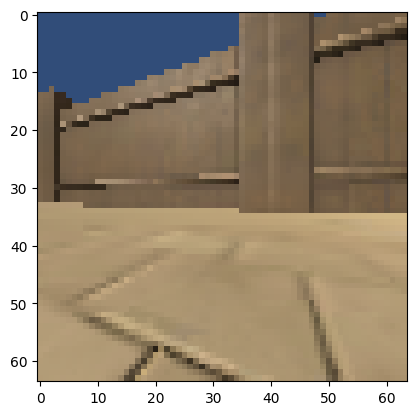

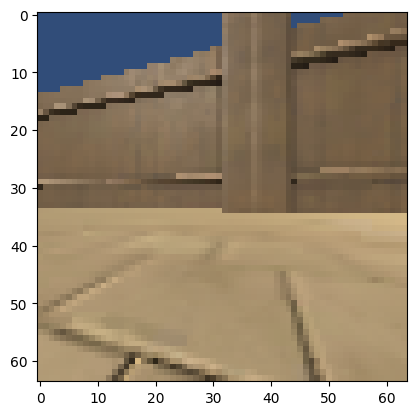

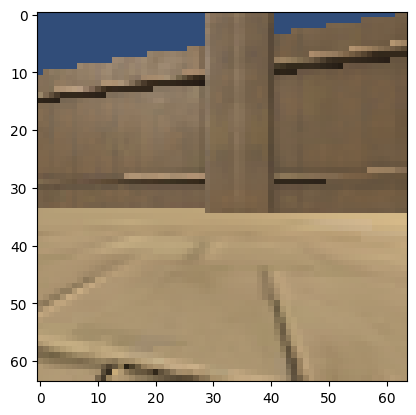

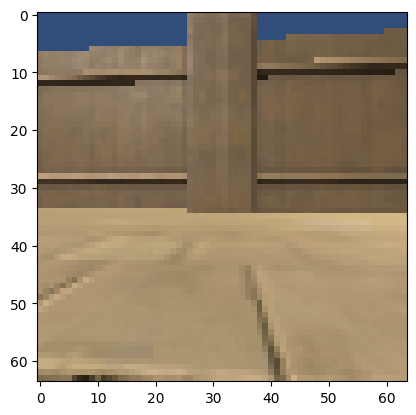

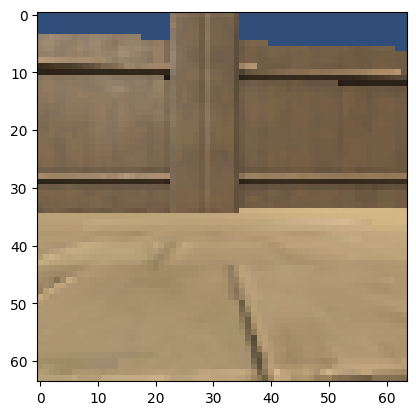

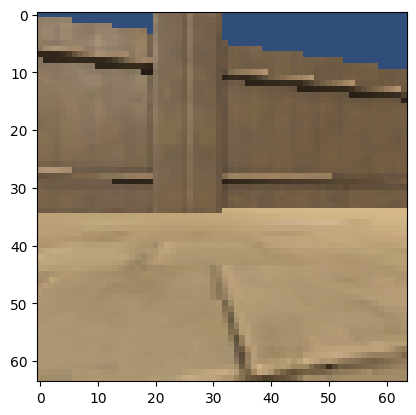

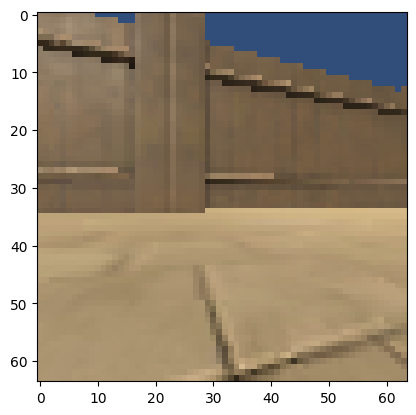

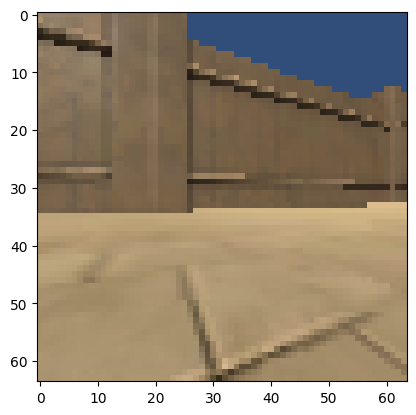

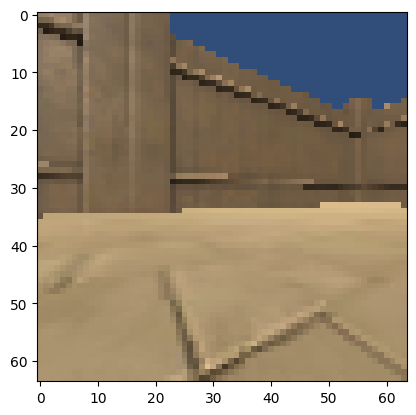

{Float64, 3}
Array{Float64, 3}
Array{Float64, 3}


In [133]:
import Random
using Plots, Images, Colors
Random.seed!(4)

# generate trace with specific initial conditions
T = 10
constraints = Gen.choicemap()
(trace, _) = Gen.generate(model, (T,), constraints)

# extract the observed data (zs) from the trace
choices = Gen.get_choices(trace)

py"""
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import display, clear_output
"""

for t=1:T
    py"""
    def display_obs(obs):
        plt.imshow(obs.reshape((resolution, resolution,3)))
        plt.figure()
    """
    py"display_obs"(choices[(:obs, t)])
    println(typeof(choices[(:obs, t)]))
end

In [142]:
function particle_filter(num_particles::Int, obss::Vector{Array{Float64, 3}}, num_samples::Int)
    
    # construct initial observations
    init_obs = Gen.choicemap(((:obs, 1), obss[1]))
    state = Gen.initialize_particle_filter(model, (0,), init_obs, num_particles)
    ptot = []
    # steps
    push!(ptot, Gen.sample_unweighted_traces(state, num_samples))
    for t=1:length(obss)-1
        print(t)
        Gen.maybe_resample!(state, ess_threshold=num_particles/2)
        obs = Gen.choicemap(((:obs, t), obss[t+1]))
        Gen.particle_filter_step!(state, (t,), (UnknownChange(),), obs)
        push!(ptot, Gen.sample_unweighted_traces(state, num_samples))
    end
    
    # return a sample of unweighted traces from the weighted collection
    return ptot
end;

In [143]:

# Generate actual observations
py"""
def gen_obs(cur_node, yaml_data):
    new_yaml_data = set_pose(yaml_data, cur_node)
    environment.reset(arenas_configurations=new_yaml_data)
    environment.step()
    step_result = environment.get_step_result(agent_group)
    visual_observation = step_result.obs[0]
    print(type(visual_observation))
    return visual_observation
"""
r = 10
x = 20
z = 15
obss = []
for i in 1:T
    vis = py"gen_obs"([x, 0, z, r], py"yaml_data")
    cvis = reshape(vis, (size(vis, 2), size(vis, 3), size(vis, 4)) )
    ccvis = convert(Array{Float64, 3}, cvis)
    push!(obss, ccvis) 
    r = (r+6)%360
end

cv_obss = convert( Vector{Array{Float64, 3}}, obss)

@time pf_traces_ot = particle_filter(50, cv_obss, 50);


123456789 16.976199 seconds (341.16 k allocations: 753.205 MiB, 0.18% gc time)


Vector{Gen.DynamicDSLTrace}
76.77435426285801
245.76552772665028
282.74558967829665
177.53539657230803
258.6126605763929
162.4849505797396
282.74558967829665
258.6126605763929
50.647725653646596
221.71525277857853
278.82007142547866
2.5382749324913334
336.8270248775832
341.3827368856222
49.154410207315195
173.17686312997117
262.80559316898683
221.71525277857853
190.18171316111147
177.53539657230803
73.56718876926112
31.507527650740876
2.5382749324913334
76.77435426285801
252.59482695048052
95.96191575024616
173.17686312997117
34.07669905532616
220.44177056031134
341.3827368856222
296.44350272560285
34.07669905532616
252.59482695048052
22.18818215288465
304.3711914819722
151.93237128211766
106.78641945576634
62.78947153082166
188.8268577643236
268.54754868368366
359.7198576047018
228.25618332889326
268.54754868368366
271.39425883920865
62.78947153082166
268.54754868368366
188.8268577643236
76.77435426285801
118.34056106434295
47.5355966849842
47.5355966849842
2.5382749324913334
47.53559

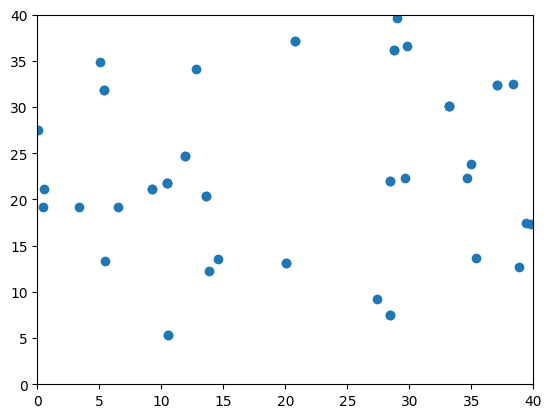

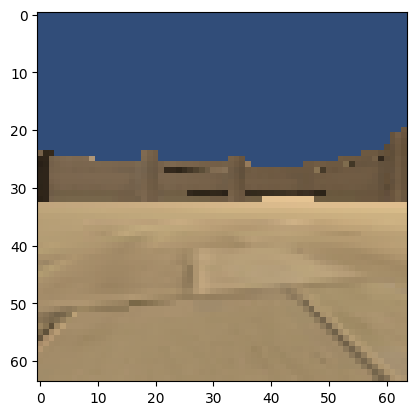

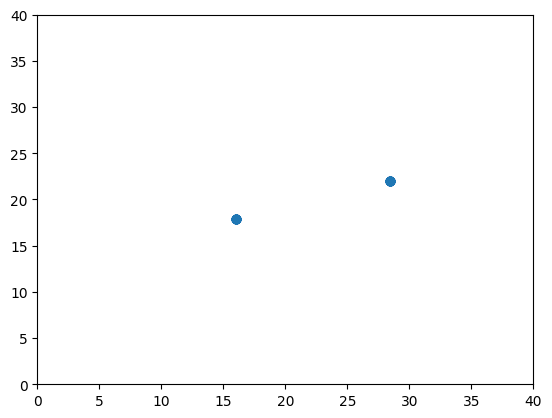

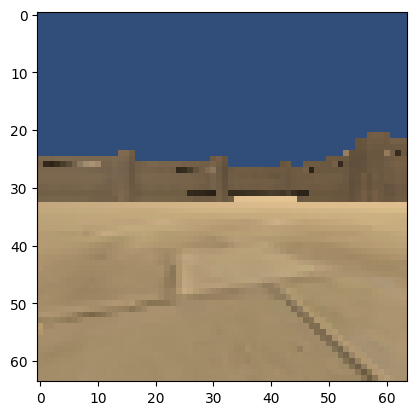

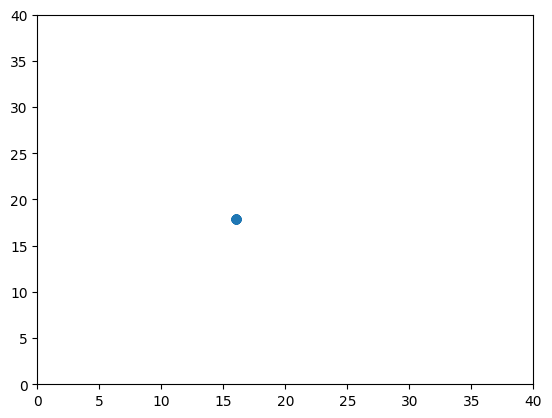

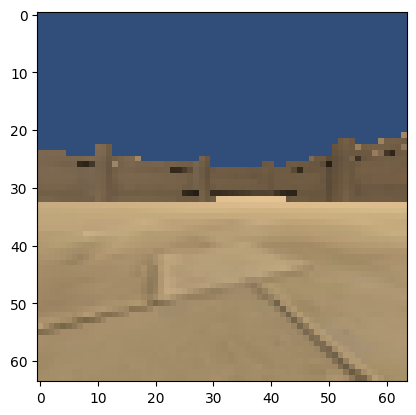

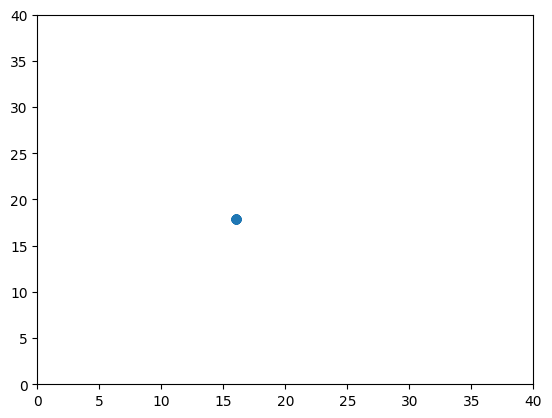

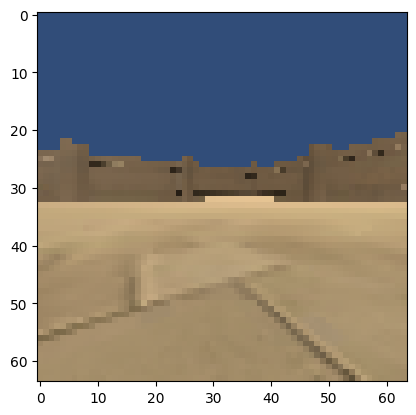

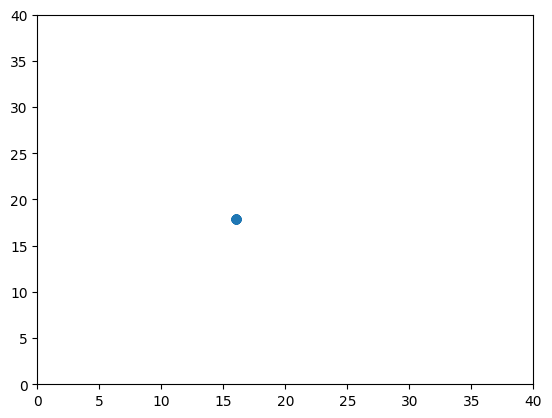

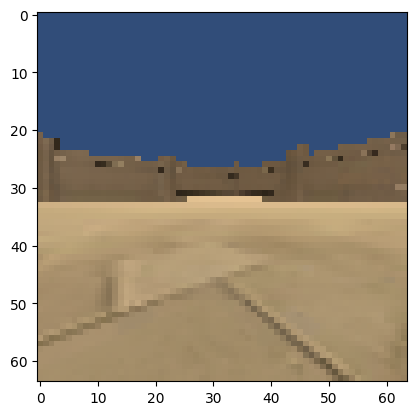

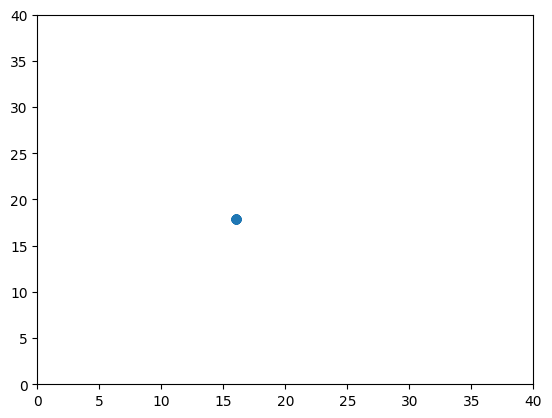

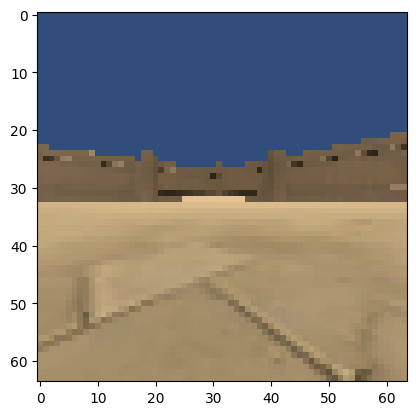

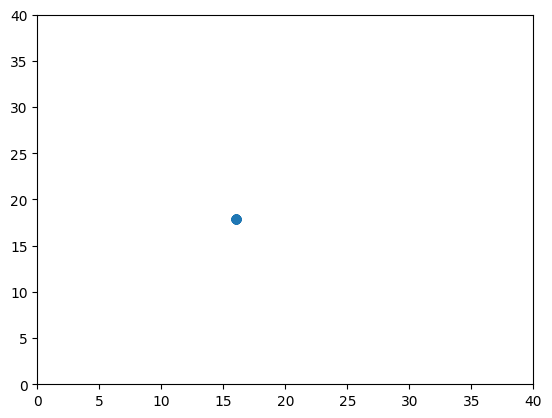

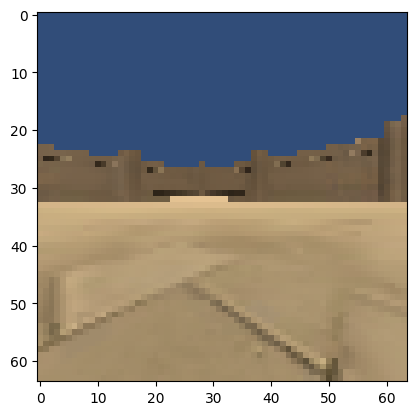

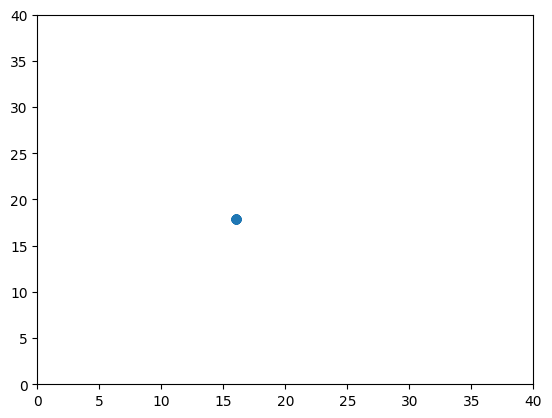

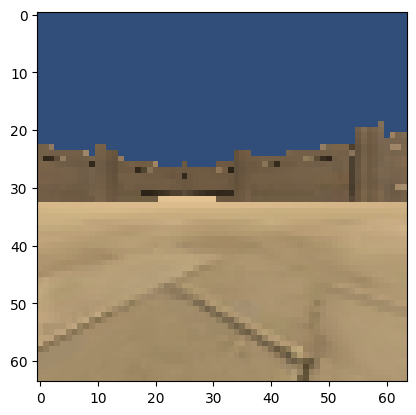

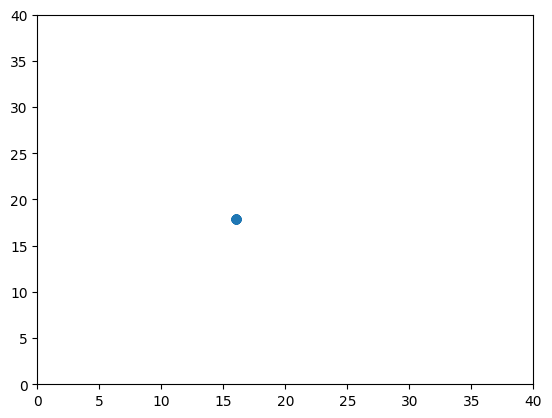

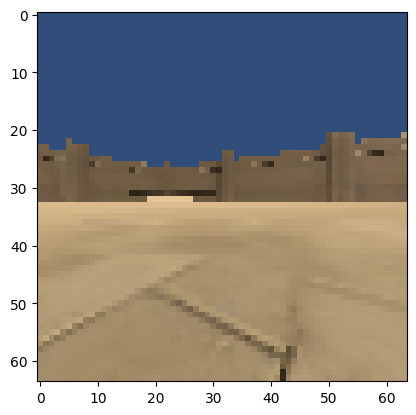

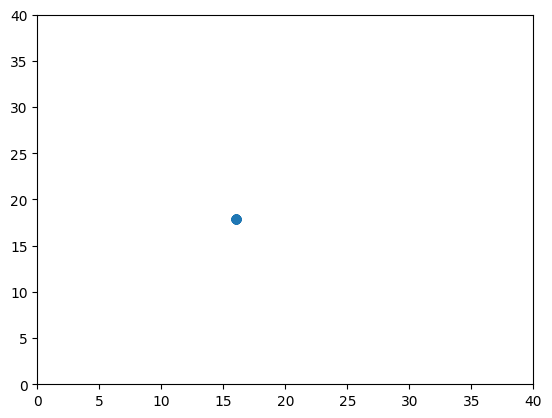

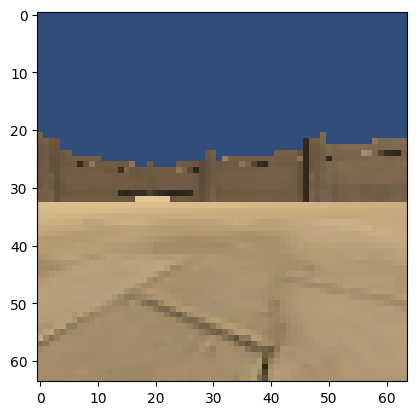


47.5355966849842
47.5355966849842
47.5355966849842
47.5355966849842
47.5355966849842
47.5355966849842
47.5355966849842
47.5355966849842
47.5355966849842
47.5355966849842
47.5355966849842
47.5355966849842
47.5355966849842
47.5355966849842
47.5355966849842
47.5355966849842
47.5355966849842
47.5355966849842
47.5355966849842
47.5355966849842
47.5355966849842
47.5355966849842
47.5355966849842
47.5355966849842
47.5355966849842
47.5355966849842
47.5355966849842
47.5355966849842
47.5355966849842
47.5355966849842
47.5355966849842
47.5355966849842
47.5355966849842
47.5355966849842
47.5355966849842
47.5355966849842
47.5355966849842
47.5355966849842
47.5355966849842
47.5355966849842
47.5355966849842
47.5355966849842
47.5355966849842
47.5355966849842
47.5355966849842
47.5355966849842
47.5355966849842
47.5355966849842


In [145]:
println(typeof(pf_traces))

for j=1:length(pf_traces_ot)
    points = []
    for i=2:length(pf_traces_ot[j])
        choices = Gen.get_choices(pf_traces_ot[j][i])
        push!(points, [choices[:x0], choices[:y0]])
    end
    py"""
    def plot_points(points):
        plt.scatter([point[0] for point in points], [point[1] for point in points])
        plt.ylim(0, 40)
        plt.xlim(0, 40)
        plt.figure()
    """
    py"plot_points"(points)
    py"display_obs"(cv_obss[j])
    
end


┌ Warning: linestyle 5 is unsupported with Plots.GRBackend().  Choose from: [:auto, :solid, :dash, :dot, :dashdot, :dashdotdot]
└ @ Plots /Users/aidancurtis/.julia/packages/Plots/lzHOt/src/args.jl:1238
┌ Warning: linestyle 5 is unsupported with Plots.GRBackend().  Choose from: [:auto, :solid, :dash, :dot, :dashdot, :dashdotdot]
└ @ Plots /Users/aidancurtis/.julia/packages/Plots/lzHOt/src/args.jl:1238
┌ Warning: linestyle 5 is unsupported with Plots.GRBackend().  Choose from: [:auto, :solid, :dash, :dot, :dashdot, :dashdotdot]
└ @ Plots /Users/aidancurtis/.julia/packages/Plots/lzHOt/src/args.jl:1238
┌ Warning: linestyle 5 is unsupported with Plots.GRBackend().  Choose from: [:auto, :solid, :dash, :dot, :dashdot, :dashdotdot]
└ @ Plots /Users/aidancurtis/.julia/packages/Plots/lzHOt/src/args.jl:1238
┌ Warning: linestyle 5 is unsupported with Plots.GRBackend().  Choose from: [:auto, :solid, :dash, :dot, :dashdot, :dashdotdot]
└ @ Plots /Users/aidancurtis/.julia/packages/Plots/lzHOt/src/arg

┌ Warning: linestyle 5 is unsupported with Plots.GRBackend().  Choose from: [:auto, :solid, :dash, :dot, :dashdot, :dashdotdot]
└ @ Plots /Users/aidancurtis/.julia/packages/Plots/lzHOt/src/args.jl:1238
┌ Warning: linestyle 5 is unsupported with Plots.GRBackend().  Choose from: [:auto, :solid, :dash, :dot, :dashdot, :dashdotdot]
└ @ Plots /Users/aidancurtis/.julia/packages/Plots/lzHOt/src/args.jl:1238
┌ Warning: linestyle 5 is unsupported with Plots.GRBackend().  Choose from: [:auto, :solid, :dash, :dot, :dashdot, :dashdotdot]
└ @ Plots /Users/aidancurtis/.julia/packages/Plots/lzHOt/src/args.jl:1238
┌ Warning: linestyle 5 is unsupported with Plots.GRBackend().  Choose from: [:auto, :solid, :dash, :dot, :dashdot, :dashdotdot]
└ @ Plots /Users/aidancurtis/.julia/packages/Plots/lzHOt/src/args.jl:1238
┌ Warning: linestyle 5 is unsupported with Plots.GRBackend().  Choose from: [:auto, :solid, :dash, :dot, :dashdot, :dashdotdot]
└ @ Plots /Users/aidancurtis/.julia/packages/Plots/lzHOt/src/arg

┌ Warning: linestyle 5 is unsupported with Plots.GRBackend().  Choose from: [:auto, :solid, :dash, :dot, :dashdot, :dashdotdot]
└ @ Plots /Users/aidancurtis/.julia/packages/Plots/lzHOt/src/args.jl:1238
┌ Warning: linestyle 5 is unsupported with Plots.GRBackend().  Choose from: [:auto, :solid, :dash, :dot, :dashdot, :dashdotdot]
└ @ Plots /Users/aidancurtis/.julia/packages/Plots/lzHOt/src/args.jl:1238
┌ Warning: linestyle 5 is unsupported with Plots.GRBackend().  Choose from: [:auto, :solid, :dash, :dot, :dashdot, :dashdotdot]
└ @ Plots /Users/aidancurtis/.julia/packages/Plots/lzHOt/src/args.jl:1238
┌ Warning: linestyle 5 is unsupported with Plots.GRBackend().  Choose from: [:auto, :solid, :dash, :dot, :dashdot, :dashdotdot]
└ @ Plots /Users/aidancurtis/.julia/packages/Plots/lzHOt/src/args.jl:1238
┌ Warning: linestyle 5 is unsupported with Plots.GRBackend().  Choose from: [:auto, :solid, :dash, :dot, :dashdot, :dashdotdot]
└ @ Plots /Users/aidancurtis/.julia/packages/Plots/lzHOt/src/arg